# Product Categorisation using ML

## Data Analysis

In [225]:
# import the desired packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
import requests
import csv
import string
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [226]:
# transform the csv file into a datframe using pd
pc_df = pd.read_csv("/Users/macbookpro/Desktop/XXXXX/Product Labelling using ML/Data/product_categorisation_data.csv")
pc_df.head()

,PRODUCT_NAME,PRODUCT_CATEGORY_1,PRODUCT_CATEGORY_2,PRODUCT_CATEGORY_3,PRODUCT_CATEGORY_4
0,Sausage & Mash,Food,Meals containing other meat and meat specialities,Not Gluten Free,Non-Vegan
1,Sausage Roll With Fried Egg,Food,Meals containing other meat and meat specialities,Not Gluten Free,Non-Vegan
2,Sausages & Mash,Food,Meals containing other meat and meat specialities,Not Gluten Free,Non-Vegan
3,Sauvignon Blanc Leefield Btl,Drinks,"Wine, Champagne and Prosecco",Not Gluten Free,Non-Vegan
4,Sauvignon Blanc Kleine Zalze Cellar Selection,Drinks,"Wine, Champagne and Prosecco",Not Gluten Free,Non-Vegan


In [227]:
# rename the columns for simplicity
pc_df.rename(columns = {'PRODUCT_NAME':'product name', 'PRODUCT_CATEGORY_1':'category 1', 
                       'PRODUCT_CATEGORY_2':'category 2','PRODUCT_CATEGORY_3':'category 3', 
                       'PRODUCT_CATEGORY_4':'category 4'}, inplace=True)

In [228]:
# divide the dataset into 2 separate ones for each category
df_c1 = pc_df.loc[: ,['product name', 'category 1']]
df_c2 = pc_df.loc[: ,['product name', 'category 2']]

In [233]:
# analyse the datasets to find any problems
new_dfs = [df_c1, df_c2]
for i in range(len(new_dfs)):
    print(new_dfs[i].groupby('category ' + str(i+1)).count().sort_values(by=['product name']))

                product name
category 1                  
Other products           964
Food                    1880
Drinks                  3325
                                                   product name
category 2                                                     
Soup                                                         16
Pasta Dishes                                                 26
Pork dishes                                                  30
Souces                                                       40
Other drinks                                                 52
Pizza                                                        53
NUTS AND SNACKS                                              56
Burger                                                       65
Salads and vegetables                                        76
Bread and bread other specialties                            82
Beef dishes                                                  87
Breakfast              

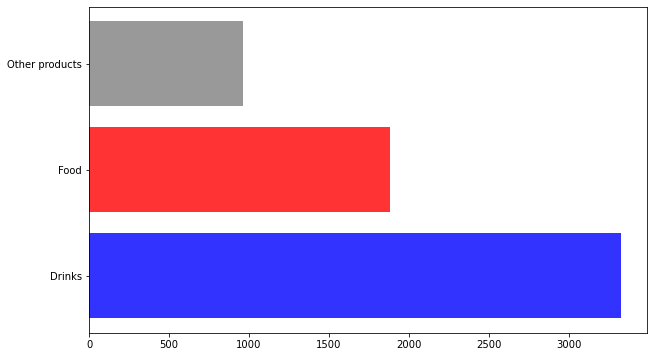

In [262]:
# plot distribution for first category
fig, ax = plt.subplots(figsize=(10,6))
df_c11 = df_c1.groupby('category 1').count().sort_values(by=['product name'], ascending = False)
plt.barh(df_c11.index, df_c11['product name'], color = ['blue', 'red', 'grey'], alpha = 0.8)
plt.savefig('bar1.png')

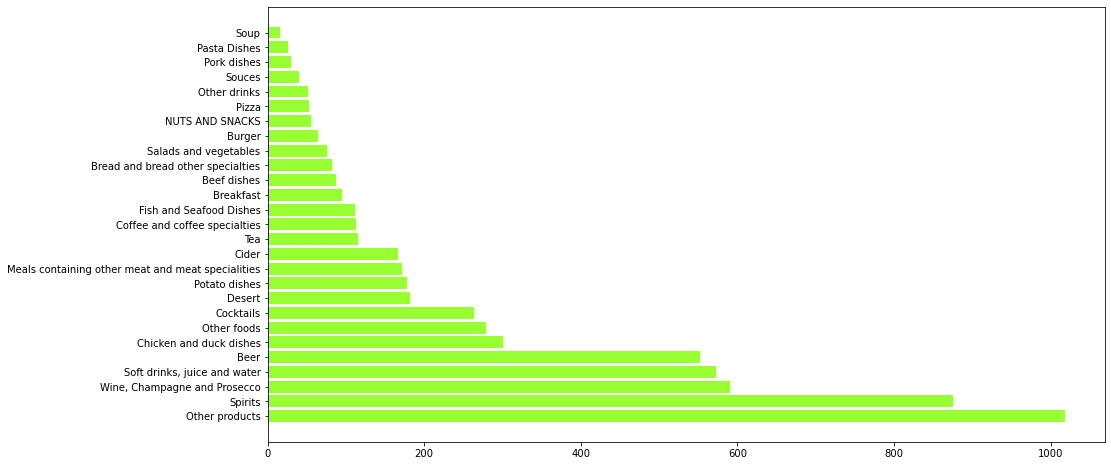

In [274]:
# plot distribution for second category
fig, ax = plt.subplots(figsize=(15,8))
df_c22 = df_c2.groupby('category 2').count().sort_values(by=['product name'], ascending = False)
plt.barh(df_c22.index, df_c22['product name'], color = 'chartreuse', alpha = 0.8)
plt.savefig('bar2.png')

## Web Scrapping

In [325]:
def webscrape(url, label, i):
    data = requests.get(url).text
    soup = BeautifulSoup(data,"html5lib")

    df = pd.DataFrame(columns=["product name","category 1","category 2","category 3","category 4"])
    for row in soup.find_all('tbody')[i].find_all('tr')[1:]:
        cols = row.find_all('td')
        if cols[0].find('a') is not None:
            name = cols[0].find_all('a')[-1].getText()
        else:
            name = cols[0].getText()[:-1]
        df = df.append({"product name" : name, "category 1" : "Food", "category 2" : label,
                        "category 3" : "Not Gluten Free", "category 4" : "Non-Vegan"}, ignore_index=True)
    return df

### Soup

In [326]:
soup_df = webscrape("https://en.wikipedia.org/wiki/List_of_soups", "Soup", 0)
soup_df = soup_df.iloc[:80, :]

### Salads

In [327]:
veg_df = webscrape("https://en.wikipedia.org/wiki/List_of_salads", "Salads and vegetables", 0)

### Pasta

In [328]:
pasta_df = webscrape("https://en.wikipedia.org/wiki/List_of_pasta_dishes", "Pasta Dishes", 1)

### Pork Dishes

In [329]:
pork_df = pd.DataFrame(columns=["product name","category 1","category 2","category 3","category 4"])

for i in range(1,8):
    url = "https://www.bbcgoodfood.com/search/recipes/page/"+str(i)+"/?q=pork+dishes&sort=-relevance"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"html5lib")

    for item in soup.find('div', {"class" : "container template-search-universal__section"}).find('div', {"class" : "row"}).find_all('div', 
                                {"class" : "col-12 template-search-universal__card"}):
        name = item.find('h4').getText()
        pork_df = pork_df.append({"product name" : name[2:-5], "category 1" : "Food", "category 2" : "Pork dishes",
                        "category 3" : "Not Gluten Free", "category 4" : "Non-Vegan"}, ignore_index=True)

### Pizza

In [330]:
pizza_df = pd.DataFrame(columns=["product name","category 1","category 2","category 3","category 4"])

for i in range(1,5):
    url = "https://www.taste.com.au/search-recipes/?page="+str(i)+"&q=pizza&sort=relevance"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"html5lib")

    for item in soup.find('ol', {"class" : "col-items-3 col-items-xs-2"}).find_all('li', 
                                {"class" : "col-xs-6 col-md-4"}):
        name = item.find('h3').getText()
        pizza_df = pizza_df.append({"product name" : name, "category 1" : "Food", "category 2" : "Pizza",
                        "category 3" : "Not Gluten Free", "category 4" : "Non-Vegan"}, ignore_index=True)

### Burger

In [331]:
burger_df = webscrape("https://en.wikipedia.org/wiki/List_of_hamburgers", "Burger", 0)

### Sauces

In [332]:
sauce_df = pd.DataFrame(columns=["product name","category 1","category 2","category 3","category 4"])
url = "https://en.wikipedia.org/wiki/List_of_sauces"
data = requests.get(url).text
soup = BeautifulSoup(data,"html5lib")

for i in range(6,33):
    for item in soup.find_all('ul')[i].find_all('li'):
        if item.find('a') is not None:
            name = item.find('a').getText()
        else:
            name = item.getText()
        sauce_df = sauce_df.append({"product name" : name, "category 1" : "Food", "category 2" : "Souces",
                       "category 3" : "Not Gluten Free", "category 4" : "Non-Vegan"}, ignore_index=True)
sauce_df = sauce_df.iloc[:100, :]

### Spirits

In [333]:
spirits_df = pc_df[pc_df['category 2']=='Spirits']
spirits_df = spirits_df.iloc[:500, :]

### Beef Dishes

In [334]:
beef_df = pd.DataFrame(columns=["product name","category 1","category 2","category 3","category 4"])

for i in range(1,5):
    url = "https://www.bbcgoodfood.com/search/recipes/page/"+str(i)+"/?q=Beef+recipes&sort=-relevance"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"html5lib")

    for item in soup.find('div', {"class" : "container template-search-universal__section"}).find('div', {"class" : "row"}).find_all('div', 
                                {"class" : "col-12 template-search-universal__card"}):
        name = item.find('h4').getText()
        beef_df = beef_df.append({"product name" : name[2:-5], "category 1" : "Food", "category 2" : "Beef dishes",
                        "category 3" : "Not Gluten Free", "category 4" : "Non-Vegan"}, ignore_index=True)


## Data Preprocessing

In [335]:
# remove the products that do not have a defined class from the original dataset
pc_df = pc_df[((pc_df["category 2"] != 'Other products') &
               (pc_df["category 2"] != 'Other foods') &
               (pc_df["category 2"] != 'Other drinks') &
               (pc_df["category 2"] != 'Meals containing other meat and meat specialities') &
               (pc_df["category 2"] != 'Spirits'))]

In [733]:
# add the webscrapped data to our table
final_df = pd.concat([pc_df, sauce_df, burger_df, pizza_df, pork_df, pasta_df, veg_df, soup_df, spirits_df, beef_df])

In [337]:
# Preprocess the data to remove any punctuation, number or capital letter
def preprocess_products(data):
    
    product_names = data.loc[:, ['product name']]
    label1 = data.loc[:, ['category 1']]
    label2 = data.loc[:, ['category 2']]
    label3 = data.loc[:, ['category 3']]
    label4 = data.loc[:, ['category 4']]
    
    cleaned_product_name = []
    numbers = '0123456789'
    
    for product in product_names.values.ravel():
        product = product.lower()
        for word in product:
            if word in string.punctuation:
                product = product.replace(word, '')
            if word in numbers:
                product = product.replace(word, '')
        cleaned_product_name.append(product)
        
    df = pd.DataFrame(list(zip(cleaned_product_name, label1.values.ravel(), label2.values.ravel(), 
                label3.values.ravel(), label4.values.ravel())), columns =['product name','category 1', 'category 2',
                                                                         'category 3', 'category 4']) 
    
    return df

In [338]:
final_cleaned_df = preprocess_products(final_df)
final_cleaned_df.loc[: ,['product name', 'category 2']].groupby('category 2').count().sort_values(by=['product name'])

,product name
category 2,
NUTS AND SNACKS,56
Bread and bread other specialties,82
Breakfast,95
Soup,96
Burger,102
Fish and Seafood Dishes,112
Coffee and coffee specialties,113
Tea,115
Souces,140


## Naive Bayes Classifier

In [278]:
# update 4 separate categories
updated_df = pd.read_excel('/Users/macbookpro/Desktop/OrderPay/Product Labelling using ML/Data/updated_pc_df.xlsx')
df_c1 = updated_df.loc[: ,['product_name', 'category_1']]
df_c2 = updated_df.loc[: ,['product_name', 'category_2']]
df_c3 = updated_df.loc[: ,['product_name', 'category_3']]
df_c4 = updated_df.loc[: ,['product_name', 'category_4']]

In [279]:
categories_1 = [i for i in df_c1.groupby('category_1').count().index]
categories_2 = [i for i in df_c2.groupby('category_2').count().index]
categories_3 = [i for i in df_c3.groupby('category_3').count().index]
categories_4 = [i for i in df_c4.groupby('category_4').count().index]

### Category 1: Food and Drinks

The accuracy is 97.24%


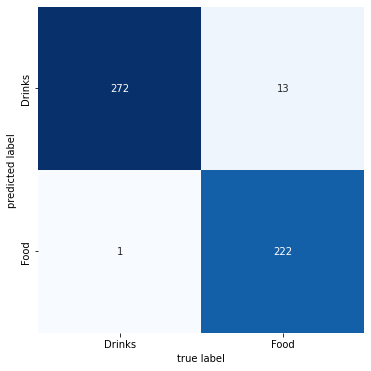

In [280]:
# Hierarchy 1
df_c1 = df_c1.dropna() # drop any NaN value
X_1 = df_c1['product_name'] # Independent variable X is the product name
Y_1 = df_c1['category_1'] # Dependent variable Y is the final label

# split the data into test and train datasets
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size = 0.10, random_state = 101)

# generate machine learning model as a pipeline of tokenisation and multinomial naive bayes
model_1 = make_pipeline(TfidfVectorizer(binary = True, max_df = 0.1, norm = 'l2'), 
                        MultinomialNB(alpha = 0.9, fit_prior = True)) # pipeline creation
model_1.fit(x_train_1, y_train_1) # fitting the model
labels_1 = model_1.predict(x_test_1) # use the model to predict the test set

# plot a confusion matrix to evaluate and compare the results
fig, ax = plt.subplots(figsize=(6,6)) # set the figure plot
mat = confusion_matrix(y_test_1, labels_1) # set the matrix row as the true label and the column as the predicted
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = categories_1,
            yticklabels = categories_1, cmap="Blues")
plt.xlabel('true label') # set the x axis label
plt.ylabel('predicted label')# set the y axis label
plt.savefig('heat_map_results.png')# save the figure plot

# test accuracy
print("The accuracy is {}%".format(round(accuracy_score(y_test_1, labels_1)*100,2)))

# final function to call in order to predict any given string
def predict_hierarchy_1(product_name, model = model_1):
    pred = model_1.predict([product_name])
    return pred[0]

In [195]:
misclassified_samples = pd.DataFrame(data = {'product name': x_test_1[y_test_1 != labels_1], 
                                             'predicted label': labels_1[y_test_1 != labels_1]})
misclassified_samples.head(60)

,product name,predicted label
3814,beurre blanc,Drinks
1593,white toast,Drinks
4284,scrippelle ‘mbrusse,Drinks
4449,bakso,Drinks
4305,testaroli,Drinks
4282,scarpinocc,Drinks
3452,fourpure oatmeal stout,Drinks
3790,satsebeli,Drinks
356,purple broccolli,Drinks
3828,bagna càuda,Drinks


In [592]:
# Hyperparameters tuning 2
df_c2 = df_c2.dropna() # drop any NaN value
X_2 = df_c2['product name'] # Independent variable X is the product name
Y_2 = df_c2['category 2'] # Dependent variable Y is the final label

# split the data into test and train datasets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.25, random_state=100)

grid_params = {
  'tfidf_vectorizer__max_df': np.linspace(0.1, 1, 10),
  'tfidf_vectorizer__binary': [True, False],
  'tfidf_vectorizer__norm': [None, 'l1', 'l2'], 
  'mnb__alpha': np.linspace(0.5, 1.5, 6),
  'mnb__fit_prior': [True, False],
}

# generate machine learning model as a pipeline of tokenisation and multinomial naive bayes
model_2 = Pipeline([('tfidf_vectorizer',TfidfVectorizer()),('mnb', MultinomialNB())]) # pipeline creation

clf = GridSearchCV(model_2, grid_params)
clf.fit(x_train_2, y_train_2)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.8640897767912195
Best Params:  {'mnb__alpha': 0.5, 'mnb__fit_prior': False, 'tfidf_vectorizer__binary': True, 'tfidf_vectorizer__max_df': 0.1, 'tfidf_vectorizer__norm': 'l1'}


The accuracy is 90.75%


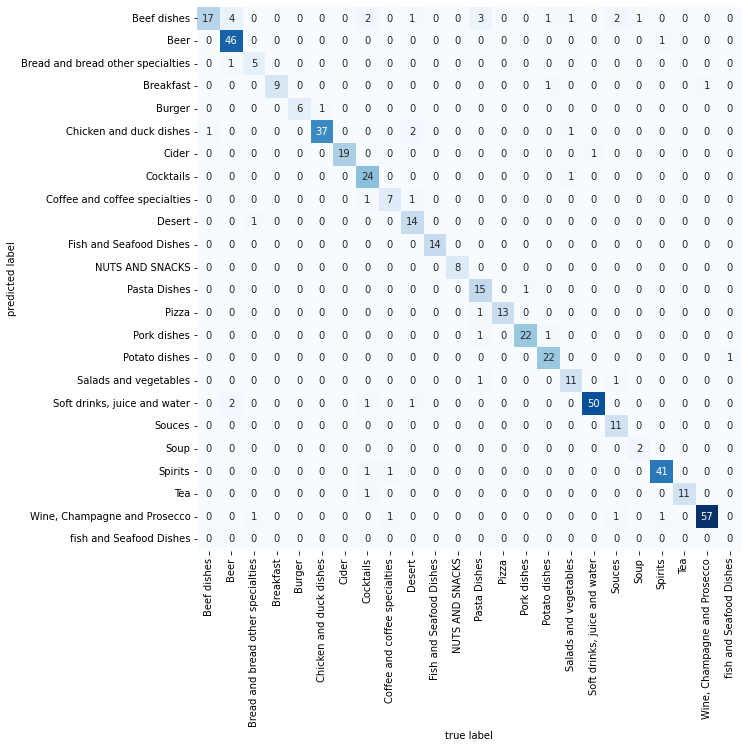

In [208]:
# Hierarchy 2
df_c2 = df_c2.dropna() # drop any NaN value
X_2 = df_c2['product name'] # Independent variable X is the product name
Y_2 = df_c2['category 2'] # Dependent variable Y is the final label

# split the data into test and train datasets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.10, random_state=101)

# generate machine learning model as a pipeline of tokenisation and multinomial naive bayes
model_2 = make_pipeline(TfidfVectorizer(binary = False, max_df = 0.1, norm = 'l1'), 
                        MultinomialNB(alpha = 0.5, fit_prior = False)) # pipeline creation

model_2.fit(x_train_2, y_train_2) # fitting the model
labels_2 = model_2.predict(x_test_2) # use the model to predict the test set

# plot a confusion matrix to evaluate and compare the results
fig, ax = plt.subplots(figsize=(10,10))
mat = confusion_matrix(y_test_2, labels_2)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = categories_2,
            yticklabels = categories_2, cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('heat_map_results.png')

# test accuracy
print("The accuracy is {}%".format(round(accuracy_score(y_test_2, labels_2)*100,2)))

# final function to call in order to predict any given string
def predict_hierarchy_2(product_name, model = model_2):
    pred = model_2.predict([product_name])
    return pred[0]

In [209]:
misclassified_samples = pd.DataFrame(data = {'product name': x_test_2[y_test_2 != labels_2], 
                                             'predicted label': labels_2[y_test_2 != labels_2],
                                            'true label': y_test_2[y_test_2 != labels_2]})
misclassified_samples.head(60)

,product name,predicted label,true label
2484,fever tree ginger ale,"Soft drinks, juice and water",Beer
4361,glorified rice,Chicken and duck dishes,Salads and vegetables
3826,salad cream,Salads and vegetables,Souces
3814,beurre blanc,"Wine, Champagne and Prosecco",Souces
1593,white toast,"Wine, Champagne and Prosecco",Bread and bread other specialties
2543,ham cheese carbonara,Pizza,Pasta Dishes
1757,prahva,Beef dishes,Beer
1563,triple chicken footlong combo,Burger,Chicken and duck dishes
220,hand battered cod and chips,Potato dishes,fish and Seafood Dishes
755,lowenbrau,Beef dishes,Beer
